# Lecture 7: Experimental Design, the HRF and Convolution

## Goals
- **Neuroscience / Neuroimaging concepts**
    * Experimental Design 
    * Block Design vs. Event-Related Design
    * Block Design Analysis (Average Response)
    * Accounting for the fMRI hemodynamic response function (HRF)
- **Datascience / Coding concepts**
    * Impulse Response Functions
    * Vectors and Matrices
    * Array Preallocation
    * Stimulus and Response Vectors
    * Time-series Convolution

# Key Terms and Concepts

Below is a list of the key terms and concepts you should know after this lecture. The list below are links to the sections of the notebook where you can learn more about each term/concept.

<br/>
<div style="font-size:15pt;">
    
1.  [Experimental Design](#Experimental_Design) <br/>
2.  [Block Design](#Block_Design) <br/>
3.  [Event-Related Design](#Event_Related_Design) <br/>
4.  [Vector](#Vector_Matrix) <br/>
5.  [Matrix](#Vector_Matrix) <br/>
6.  [Stimulus Vector](#Stimulus_Vector) <br/>
7.  [Design Matrix](#Design_Matrix) <br/>
8.  [Array Preallocation](#Preallocation) <br/>
9.  [Impluse Response Function](#Impulse_Response_Function) <br/>
10. [HRF](#HRF) <br/>
11. [Response Vector](#Response_Vector) <br/>
12. [Convolution](#Convolution) <br/>
</div>

# Standard Imports

This cell will import the Python modules needed for today's lecture. Simply run this cell.

In [1]:
# Load some necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import nibabel
import cortex
import os
from __future__ import print_function
from ipywidgets import interact, Image, widgets

# Set plotting defaults
%matplotlib inline

## Data Preparation

This cell will load data necessary for today's lecture. Simply run these cells.

In [2]:
data_filename = "/home/jovyan/s01_categories_all_z.nii"
categories_filename = "/home/jovyan/catloc_experimental_conditions.npy"

If you don't have the data from the midterm for some reason, uncomment the cell below (select all the code and press "ctrl /") and execute it. This will download the data file.

In [ ]:
# import urllib.request
# import zipfile
# zname, _ = urllib.request.urlretrieve("https://berkeley.box.com/shared/static/hcu0khw2spowgd1winlfi4f3si7lk1ua.zip", 
#                                       "/home/jovyan/midterm_data.zip")
# zfile = zipfile.ZipFile(zname)
# zfile.extractall("/home/jovyan")

Create a cortical Mask

In [3]:
subject = 's01'
transform = 'catloc'

cortical_mask = cortex.db.get_mask(subject, transform, type='cortical')
cortical_mask.shape

(30, 100, 100)

And load the data, mask it, and demean it for different uses in today's lecture.

In [4]:
img = nibabel.load(data_filename)
data = img.get_data().T
data_cortex = data[:, cortical_mask]
data_cortex_demean = data_cortex - data_cortex.mean(axis=0)

## Helper Functions
Run these cells to load helper functions we'll use during class today.

In [5]:
def load_nifti(file_name, mask=None):
    img = nibabel.load(file_name)
    data = img.get_data().T
    if mask is None:
        masked_data = data
    else:
        masked_data = data[:, mask]
    return masked_data

In [6]:
def get_mask_idx(mask, z, y, x):
    indices = np.arange(np.prod(mask.shape)).reshape(*mask.shape)
    indices_masked = indices[mask]
    return np.where(indices_masked == indices[z,y,x])[0][0]

<a id="Experimental_Design"></a>
# Experimental design

Cognitive neuroscientists conduct fMRI experiments to learn something about how cognition is related to brain responses, and where in the brain those responses occur. Cognition is a term that describes mental processes such as attention, memory, perception, decision making, planning, language, motor control or emotion. Since we can't measure mental phenomena directly, we either characterize properties of stimuli used or record behavior as a proxy for the cognitive processes that we believe underlie those behaviors. Before we learn the techniques that allow neuroscientists to relate those stimuli and behaviors to brain responses, we'll first spend some time discussing how fMRI experiments are designed, and the reasons behind some of those design decisions. 

Broadly speaking, we must be concerned with 2 aspects of an experiment:

1. **Cognitive Process Elicitation:** The experiment must be designed to elicit the cognitive process or processes that we're trying to understand. This is generally done by presenting the participant with a stimulus, asking them to complete some task, or a combination of both. For example:
    * A stimulus-only experiment could involve simply showing the participant some movies while they lie in the MRI scanner and look wherever they want at the movie. This would elicit neural activity in the visual system, and the scientist could study which parts of the visual system respond to which types of stimuli.
    * A task-only experiment could involve asking the subject to start counting from 0 to 100 saying one number every second. This would elicit neural activity in the speech production region of the brain.
    * A stimulus and task experiment could involve showing participants a set of images, showing them a second set of images and asking them to indicate if they had already seen this image. This would elicit neural activity in regions responsible for encoding and retrieving memories.
    
2. **Technical Considerations:** Any experiment involves taking measurements of the phenomena being studied. Considering all the ways your measurement tools affect the data collection is crucial to collecting data that is high quality. While there are many considerations when using an MRI scanner to collect BOLD data, we will be primarily concerned with accounting for two properties of the BOLD signal: 
    * The BOLD signal is **slow**
    * The BOLD signal is **noisy**

## Block vs. event-related designs

While the first concern just mentioned (eliciting cognitive processes to study) differs from experiment to experiment, the technical considerations of doing fMRI studies are common to all. Let's explore 2 broad classes of experimental designs that deal with the two technical considerations mentioned above:
<a id="Block_Design"></a>

1\. **Block Design:** Block designs consist of presenting many stimuli (or trials types) of the same type together in a row, or a block. The BOLD response to this block of stimuli can then be averaged to investigate which brain regions respond more to a particular stimuli than others. This averaging of TRs in a block design helps to improve the SNR. This improvement in SNR from using a block design comes at a cost, however: block designs are not temporally efficient, they take a long time to show just a few different types of stimuli. Since time in the MRI machine is expensive (several hundred dollars an hour), this is not an efficient way to conduct fMRI research. Here's a schematic of an example block design alternating blocks of doing a task (T) or rest (C), along with a BOLD signal that just responds to the task.

<img src='figures/block_bold.png'  style="width: 400px">
<a id="Event_Related_Design"></a>
2\. **Event-Related Design:** In a fast event-related design experiment, many different stimuli are presented at much shorter intervals. While this design is more temporally efficient (which allows for more complex experiments), a potential problem with event-related designs is that the BOLD signal responds slowly (peaks at about 5 seconds), and so if we show many different types of stimuli in a row, the BOLD signal response from one stimulus will "bleed over" into the TRs of the neighboring stimuli. Thus, if we want to mathematically describe how the brain responds to a given stimulus, we have to incorporate this delay in order to be accurate. See the image below for an illustration of how this might be done.

<img src='figures/event_related.PNG' style="width: 400px">

This problem of "bleeding over" has a solution however, and it involves characterizing the Hemodynamic Response Function (HRF) as we'll see later in this lecture. Since event-related designs are more complex we'll wait to cover them in lecture 12, but we'll see later on today how accounting for the HRF can even benefit block design experiments!

## Stimulus Vectors

<a id='Stimulus_Vector'></a>
### Stimulus Vector Definition
A ***stimulus vector*** is a 1-D array that quantifies one piece of information about the stimulus (or task) the participant experienced during every TR of an experiment. In its simplest form it contains a `True` or `False` value indicating whether a stimulus of a given type was shown during any given TR. You created and plotted **stimulus vectors** in your midterm when you found all the TRs where a face or place was presented. 

**Stimulus vectors** can be much more complex than `True`/`False` 1-D arrays which indicate the presence or absence of a stimulus type, and we'll see examples of complex stimulus vectors in our lecture on encoding models. For now, we'll be using simple stimulus vectors that indicate the presence or absence of a type of stimulus in each TR.

<a id='Vector_Matrix'></a>
#### Note on Terminology: Vectors and Matrices
The terms **vector** and **matrix** are shorthand terms to describe 1-D and 2-D arrays respectively. So anytime we use the term **vector** we simple mean a 1-D array, and likewise **matrix** means a 2-D array.

Now let's load the data you used in the midterm containing the stimulus type of the image that was presented at each TR of an experiment, and extract stimulus vectors from that:

In [9]:
categories_filename = "/home/jovyan/catloc_experimental_conditions.npy"
category_labels = np.load(categories_filename)
print(category_labels.shape)
print(category_labels)

(360,)
['faces' 'faces' 'faces' 'faces' 'faces' 'faces' 'faces' 'faces' 'faces'
 'faces' 'object' 'object' 'object' 'object' 'object' 'object' 'object'
 'object' 'object' 'object' 'body' 'body' 'body' 'body' 'body' 'body'
 'body' 'body' 'body' 'body' 'scrambled' 'scrambled' 'scrambled'
 'scrambled' 'scrambled' 'scrambled' 'scrambled' 'scrambled' 'scrambled'
 'scrambled' 'places' 'places' 'places' 'places' 'places' 'places' 'places'
 'places' 'places' 'places' 'nothing' 'nothing' 'nothing' 'nothing'
 'nothing' 'nothing' 'nothing' 'nothing' 'nothing' 'nothing' 'object'
 'object' 'object' 'object' 'object' 'object' 'object' 'object' 'object'
 'object' 'faces' 'faces' 'faces' 'faces' 'faces' 'faces' 'faces' 'faces'
 'faces' 'faces' 'scrambled' 'scrambled' 'scrambled' 'scrambled'
 'scrambled' 'scrambled' 'scrambled' 'scrambled' 'scrambled' 'scrambled'
 'body' 'body' 'body' 'body' 'body' 'body' 'body' 'body' 'body' 'body'
 'places' 'places' 'places' 'places' 'places' 'places' 'places' 'place

Now let's see how many different types of stimuli were presented in this experiment. To do that, we'll use the function `np.unique`, which returns an array containing the unique values of the input array.

In [10]:
unique_category_labels = np.unique(category_labels)
unique_category_labels

array(['body', 'faces', 'nothing', 'object', 'places', 'scrambled'], 
      dtype='<U9')

So we've got 5 types of stimuli, plus 'nothing' where the subjects rested with no stimuli. As you did in the exam, let's create a stimulus vector that indicates where a face stimulus was present or absent:

In [11]:
stimulus_vector_faces = category_labels == 'faces'
stimulus_vector_faces.sum()

60

We took the sum of that vector above, which equaled 60. What does that tell us?

It indicates 60 face stimuli were presented during this experiment, since `True==1` and `False==0`.

Now let's create the stimulus vector for places and see how many place stimuli were presented:

In [12]:
stimulus_vector_places = category_labels == 'places'
stimulus_vector_places.sum()

60

Also 60!

#### Breakout Session

1\. Create a stimulus vector for each of the 3 remaining stimulus types from this experiment. Name them `stimulus_vector_XXXXX`, where `XXXXX` is replaced with the name of the stimulus type.

In [13]:
unique_category_labels

array(['body', 'faces', 'nothing', 'object', 'places', 'scrambled'], 
      dtype='<U9')

In [15]:
### ANSWER BREAKOUT SESSION HERE
stimulus_vector_object = category_labels == 'object'
stimulus_vector_body = category_labels == 'body'
stimulus_vector_scrambled = category_labels == 'scrambled'
stimulus_vector_object.sum()

60

<a id='Design_Matrix'></a>
### Design Matrices as Collections of Stimulus Vectors

**Stimulus vectors** are important because they quantify the experimental design (at least the cognitive process elicitation), and so are used in the mathematical analysis of the fMRI data. The collection of all the stimulus vectors for an experiment is called the ***design matrix***, as it is a numerical representation of the design of the experiment, in matrix form. In lecture 4 we learned a bit about design matrices, and how to plot them as line plots or images.

Now let's create the design matrix for this experiment!

<a id='Preallocation'></a>
#### Array Preallocation
When creating arrays (in this case a 2-D array, or matrix), it's always a good idea to **preallocate** the array if you can because it is more memory efficient. **Preallocation** is the process of determining how big your array needs to be before doing all the calculations to fill it (creating the stimulus vectors in this case). 

Let's calculate how big the design matrix needs to be now. We know the design matrix contains a value for every TR of the experiment, and every stimulus type that was used (we'll exclude the 'nothing' stimulus type because nothing actually happened there):

In [18]:
num_TRs = category_labels.shape[0]
unique_category_labels_nonothing = unique_category_labels[unique_category_labels!='nothing']
num_categories = unique_category_labels_nonothing.shape[0]
unique_category_labels_nonothing
num_TRs, num_categories 

(360, 5)

Now let's create the design matrix for this experiment:

In [19]:
design_matrix = np.zeros((num_TRs, num_categories))

#### Design Matrix Creation
And finally populate the design matrix by looping over all the stimulus types and creating the stimulus vector for each one. 

In [20]:
for cur_stim_idx in np.arange(num_categories):
    
    # get the current stimulus type (category)
    cur_category = unique_category_labels[cur_stim_idx]
    
    # create the current stimulus vector
    cur_stim_vector = category_labels == cur_category
    
    # store the current stimulus vector in the current column of the design matrix
    design_matrix[:,cur_stim_idx] = cur_stim_vector

Let's visualize the design matrix using the technique we learned in lecture 4. We'll plot it as an image, using the `aspect=auto` argument so it fills the entire figure:

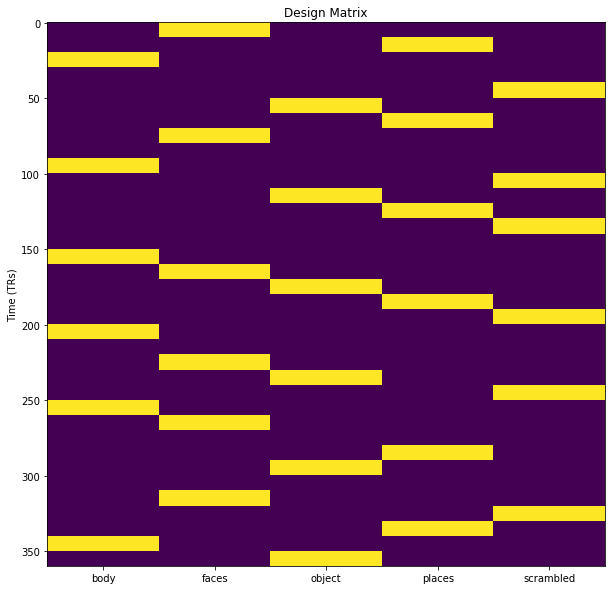

In [21]:
fig = plt.figure(figsize=(10,10))
plt.imshow(design_matrix, aspect='auto')
plt.title('Design Matrix')
plt.ylabel('Time (TRs)')
_ = plt.xticks(np.arange(num_categories), unique_category_labels_nonothing)

What do you notice about this design matrix?

Each stimulus type is being presented within a block of 10 TRs, which means 20 seconds since the TR is 2 seconds. This is a prolonged period of time during which we can be sure to evoke the brain response pertaining to each block presented. In this specific example we manage to place 6 blocks of each stimulus type into 360TRs, i.e. 12 minutes of scanning time.

#### Breakout Session

1\. Let's practice preallocating an array. To do this we'll first create two new stimulus vectors, one that represents stimulus types that are living, which we'll call **animate**, and a second which represents stimulus types that aren't living, which we'll call **inanimate**. Create a new stimulus vector called `stimulus_vector_animate` by using a logical operator that will combine the `faces` and `body` stimulus vectors into a vector that is true whenever a face OR a body was presented. Do the same for the `stimulus_vector_inanimate` with `object` and `places`.

In [26]:
### ANSWER BREAKOUT SESSION HERE
stimulus_vector_animate = stimulus_vector_faces | stimulus_vector_body
stimulus_vector_inanimate = stimulus_vector_object | stimulus_vector_places

print(stimulus_vector_inanimate.shape)
num_TRs

(360,)


360

2\. Now preallocate a design matrix that will store these 2 new stimulus vectors. Call it `design_matrix_animacy`. How many rows should it have? And how many columns?

In [28]:
### ANSWER BREAKOUT SESSION HERE
design_matrix_animacy = np.zeros((num_TRs, 2))
design_matrix_animacy.shape

(360, 2)

3\. Now fill the `design_matrix_animacy` with the `animate` and `inanimate` stimulus vectors.

In [29]:
### ANSWER BREAKOUT SESSION HERE
design_matrix_animacy[:,0] = stimulus_vector_animate
design_matrix_animacy[:,1] = stimulus_vector_inanimate

<a id='Block_Design_Analysis'></a>
## Block Design Analysis

With the stimulus vectors (and design matrix) in hand, we can begin to do a very simple analysis of this fMRI data!

When dealing with block design data the simplest analysis you can do is to find all the TRs where each stimulus type was presented and simply average the data to see if it's higher than the other signals. You've actually already done this analysis on the midterm, but let's break down every step of it. 

Let's first view the design matrix in another format, showing the time series of all the stimulus vectors. We'll use a helper function called `plot_design_matrix_line` to do this:

In [30]:
def plot_design_matrix_line(design_mat, labels):
    num_stim_types = design_mat.shape[1]
    for cur_stim_type in np.arange(num_stim_types):
        cur_y_offset = (cur_stim_type - 1) * 2
        plt.plot(design_mat[:, cur_stim_type] + cur_y_offset, label = labels[cur_stim_type])
    plt.title('Design Matrix')
    plt.xlabel('Time (TRs)')
    _ = plt.legend(bbox_to_anchor=(1, 1))

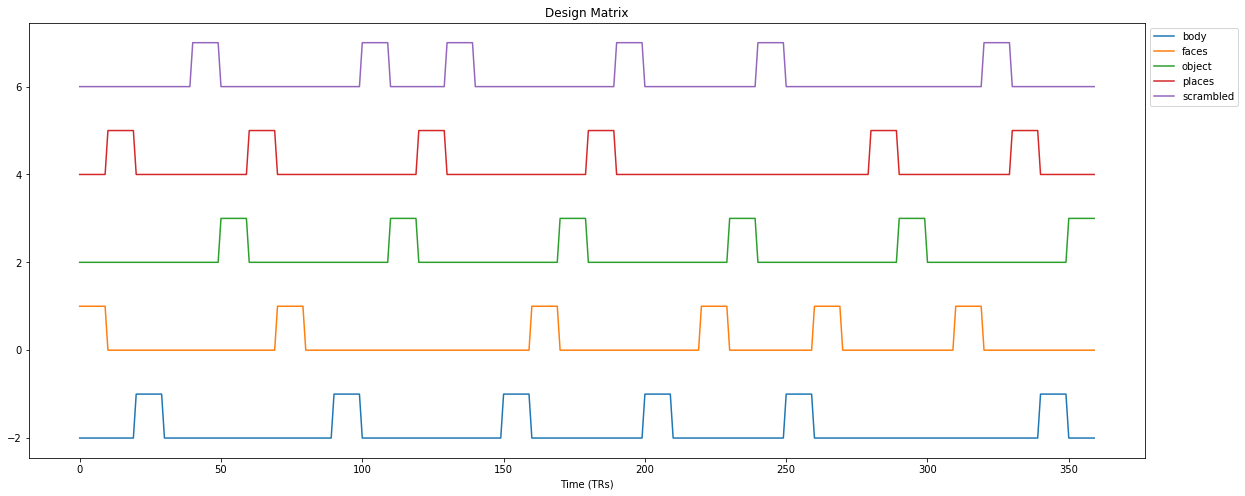

In [32]:
plt.figure(figsize=(20, 8))
plot_design_matrix_line(design_matrix, unique_category_labels_nonothing)

Before we start calculating averages let's have a look at the voxel time series from two voxels, one in a face selective region and one in a place selective region, and compare it with the stimulus vector. This will give us an idea if the average activity in these two voxels is higher than when other stimulus types are presented.

First we'll create a sequence that represents time for the voxel time series, so that we can plot the voxel time series in units of seconds instead of TRs.

In [33]:
TR = 2.0
time_whole = np.arange(0,num_TRs*2, TR)
time_whole.shape

(360,)

array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
         18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
         36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
         54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
         72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
         90.,   92.,   94.,   96.,   98.,  100.,  102.,  104.,  106.,
        108.,  110.,  112.,  114.,  116.,  118.,  120.,  122.,  124.,
        126.,  128.,  130.,  132.,  134.,  136.,  138.,  140.,  142.,
        144.,  146.,  148.,  150.,  152.,  154.,  156.,  158.,  160.,
        162.,  164.,  166.,  168.,  170.,  172.,  174.,  176.,  178.,
        180.,  182.,  184.,  186.,  188.,  190.,  192.,  194.,  196.,
        198.,  200.,  202.,  204.,  206.,  208.,  210.,  212.,  214.,
        216.,  218.,  220.,  222.,  224.,  226.,  228.,  230.,  232.,
        234.,  236.,  238.,  240.,  242.,  244.,  246.,  248.,  250.,
        252.,  254.,

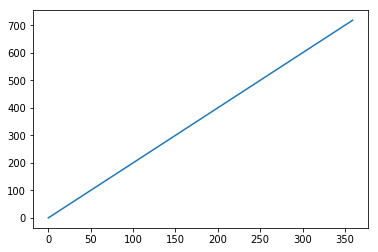

In [36]:
plt.plot(time_whole)
time_whole

Here we'll use a helper function to translate between coordinates in 3-D `(Z,Y,Z)` space into a single index into the cortical collection of voxel time series. This is done using some indexing trickery that you can have a look at, but won't be tested on.

In [37]:
ffa_voxel_idx = get_mask_idx(cortical_mask,6,57,37)
ppa_voxel_idx = get_mask_idx(cortical_mask,10,62,40)

Now we'll extract the time series for the whole experiment from both the FFA (face-selective) and PPA (face-selective) voxels.

In [38]:
ffa_timeseries = data_cortex_demean[:,ffa_voxel_idx]
ppa_timeseries = data_cortex_demean[:,ppa_voxel_idx]
ppa_timeseries.shape

(360,)

Finally we'll plot both voxels time series as line plots, and compare them with the stimulus vectors showing when faces were presented to the participant. We'll create a helper function to do the plotting first:

In [39]:
def plot_stim_data(time, data, stim, stim_type='', title=''):
    plt.plot(time, data, label='BOLD Signal')
    plt.plot(time, stim, label='%s Stimuli' % (stim_type))
    plt.xlabel('Time (seconds)')
    plt.ylabel('BOLD Signal (S.D.)')
    plt.legend()
    plt.title(title)

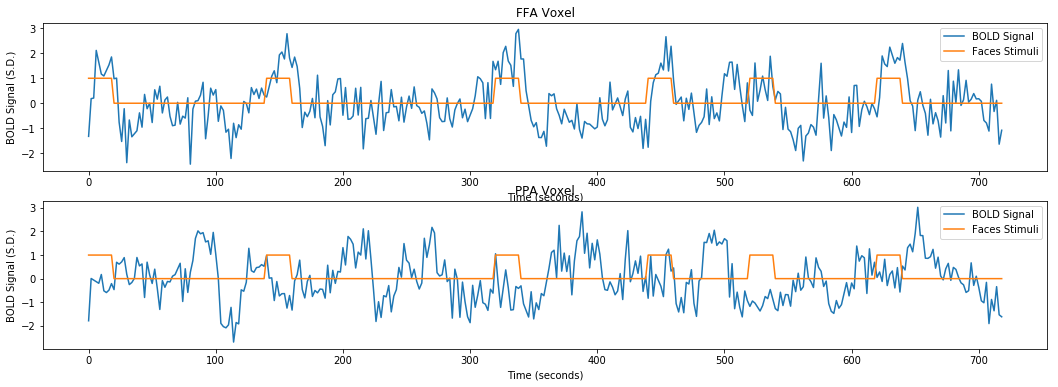

In [40]:
plt.figure(figsize=(18, 6))
plt.subplot(2,1,1)
plot_stim_data(time_whole, ffa_timeseries, stimulus_vector_faces, stim_type='Faces', title='FFA Voxel')

plt.subplot(2,1,2)
plot_stim_data(time_whole, ppa_timeseries, stimulus_vector_faces, stim_type='Faces', title='PPA Voxel')

We can see that the face selective voxel goes up when the face stimuli were shown relative to the rest of the time, which is what we'd expect. The PPA voxel does not show this same pattern, however. 

Perhaps a better way to see exactly how much the voxel increase when faces are shown, relative to all the other TRs, is to plot two histograms together. One will histogram the voxel BOLD signal values when faces where shown, and the other when faces were not shown. To do this, we'll first extract the TRs when faces were not shown:

In [41]:
ffa_face_values = ffa_timeseries[stimulus_vector_faces]
ffa_nonface_values = ffa_timeseries[~stimulus_vector_faces]

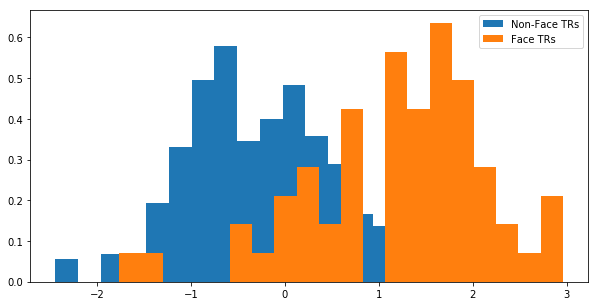

In [42]:
fig = plt.figure(figsize=(10,5))
plt.hist(ffa_nonface_values, bins=20, normed=True, label='Non-Face TRs')
plt.hist(ffa_face_values, bins=20, normed=True, label='Face TRs')
_ = plt.legend()

These two histograms are quite distinctly centered around different points, to an extent where this is visible to the eye. We can compute the average activation for each of the conditions - faces and the rest and draw vertical lines into the diagram at those locations

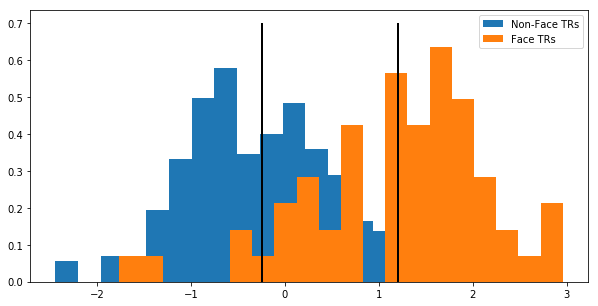

In [43]:
fig = plt.figure(figsize=(10,5))
plt.hist(ffa_nonface_values, bins=20, normed=True, label='Non-Face TRs')
plt.hist(ffa_face_values, bins=20, normed=True, label='Face TRs')
plt.vlines((ffa_nonface_values.mean(), ffa_face_values.mean()), 0, 0.7, lw=2)
_ = plt.legend()

So now that we can see there's a real difference, let's quantify how big that difference is. To do so, we need to get the data during the TRs where faces were shown, and average them.

Since the faces stimulus vector consists of `True`/`False` values, we can use it like a mask, and apply it to the collection of cortical voxel time series `data_cortex` to get all the TRs where a face was presented:

In [44]:
data_cortex_faces = data_cortex[stimulus_vector_faces, :]
data_cortex_faces.shape

(60, 38543)

Now we have the voxel time series for those TRs where a face was presented, for all the cortical voxels.

The next step in the analysis is to take the average across time for each of the voxels:

In [45]:
avg_faces_cortex = data_cortex_faces.mean(axis=0)
avg_faces_cortex.shape

(38543,)

Now we have a single value representing the average activity for faces in every cortical voxel. We can plot this on a flatmap to see what it looks like:

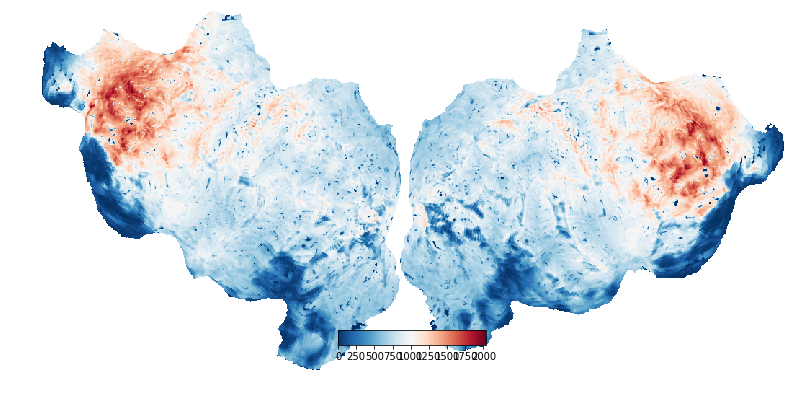

In [46]:
volume_faces_avg = cortex.Volume(avg_faces_cortex, subject=subject, xfmname=transform)
_ = cortex.quickflat.make_figure(volume_faces_avg)

Huh, this map indicates that the highest average response to faces occurred in the pre-frontal cortex, and the lowest in the ventral temporal cortex (look at a dynamic viewer to verify this for yourself!). Is the prefrontal cortex really face selective?

Remember that the BOLD signal is a relative measure of the ratio of oxygenated to deoxygenated blood, which is a proxy for neural activity. Since the BOLD signal is relative, the dominant portion of this average is just the mean signal, regardless of the difference between face response and other stimulus responses. So what the above flatmap is really getting at is closer to the mean signal we created when calculating SNR than a measure of face-selectivity.

To control for this, let's remove the mean from this data, and replot it!

In [47]:
data_cortex_faces_demean = data_cortex_demean[stimulus_vector_faces, :]
avg_faces_cortex_demean = data_cortex_faces_demean.mean(axis=0)

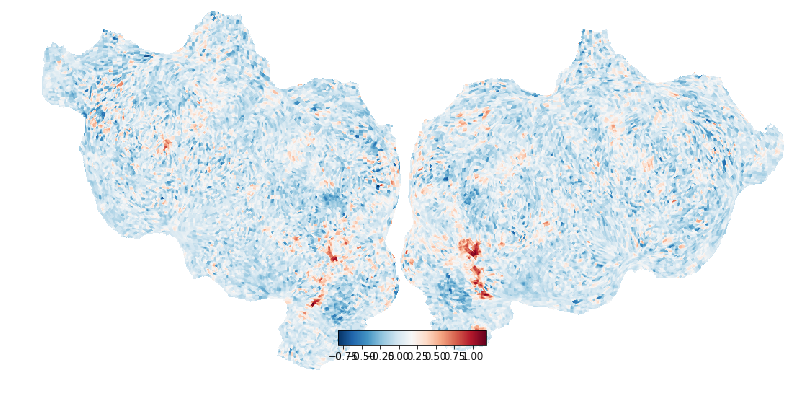

In [48]:
volume_faces_avg = cortex.Volume(avg_faces_cortex_demean, subject=subject, xfmname=transform)
_ = cortex.quickflat.make_figure(volume_faces_avg)

That looks better! We see regions in red that are in the visual cortex with high average signal, relative to the mean of each voxel's time series (since we removed that mean). We'll eventually want to compare the average signal for faces to another value that controls for cognitive processes other than face processing (like more basic visual processing), but for now this gives us a general idea of face-selective regions.

#### Breakout Session

1\. Now let's do this same analysis for the places stimuli. First let's look at the time series of both PPA and FFA voxels compared with the places stimulus vector. Use the `plot_stim_data` helper function, and `plt.subplot` to create 2 plots, one for the FFA voxel time series `ffa_timeseries`, and one for the PPA voxel time series `ppa_timeseries` along with the `stimulus_vector_places`.

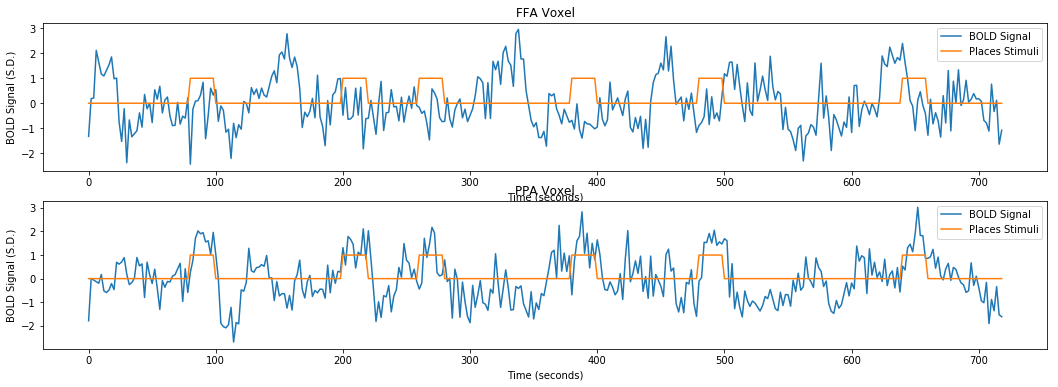

In [49]:
### ANSWER BREAKOUT SESSION HERE
plt.figure(figsize=(18, 6))
plt.subplot(2,1,1)
plot_stim_data(time_whole, ffa_timeseries, stimulus_vector_places, stim_type='Places', title='FFA Voxel')

plt.subplot(2,1,2)
plot_stim_data(time_whole, ppa_timeseries, stimulus_vector_places, stim_type='Places', title='PPA Voxel')

2\. Now extract all the TRs when the places stimuli where presented, for all cortical voxels. Remember that we can use the places stimulus vector `stimulus_vector_places` as a mask. Be sure to use the demeaned version of the data, `data_cortex_demean`, so we can see the activity relative to the mean.

In [51]:
### ANSWER BREAKOUT SESSION HERE
data_cortex_places_demean = data_cortex_demean[stimulus_vector_places, :]
data_cortex_places_demean.shape

(60, 38543)

3\. Take the average across time of these place stimuli TRs, for all the cortical voxels.

In [53]:
### ANSWER BREAKOUT SESSION HERE
avg_places_cortex_demean = data_cortex_places_demean.mean(axis=0)
avg_places_cortex_demean.shape

(38543,)

4\. Finally plot a flatmap showing the increase in activity for place stimuli relative to the mean.

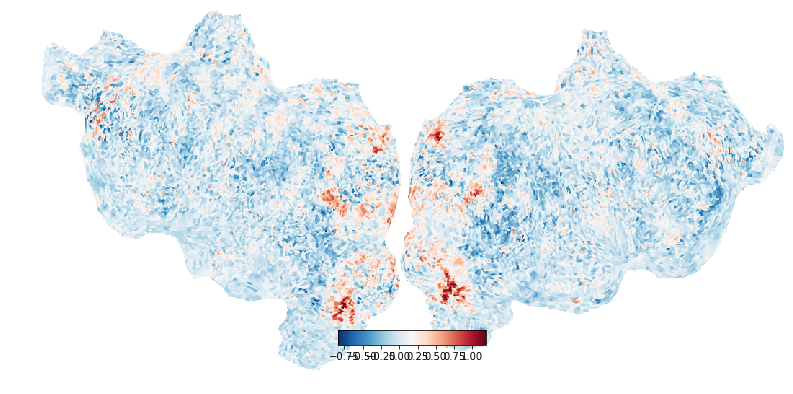

In [54]:
### ANSWER BREAKOUT SESSION HERE
volume_places_avg = cortex.Volume(avg_places_cortex_demean, subject=subject, xfmname=transform)
_ = cortex.quickflat.make_figure(volume_places_avg)

### A relevant example of block designs

Block designs were the norm in the early days of fMRI, before some critical experiments showed that event-related designs could be done. Here's an example of one of the most famous studies in all of cognitive neuroscience. 

In 1997, Kanwisher and others found a cortical area which responded strongly to faces. On of the figures from the paper shows the BOLD timeseries comparing the presentation of faces to the presentation of other stimuli

<img src='figures/F1.large.jpg'>

Does the experimental design of this study look familiar?

# Accounting for the HRF

The analysis that we just did by averaging activity in the blocks for each stimulus type gave us some encouraging results, but we can do better if we account for the slow BOLD dynamics of the HRF. Additionally, accounting for the HRF will allow us to do event-related designs later on in this course.

<a id="Impulse_Response_Function"></a>
### Impulse Response Functions
To characterize the HRF, we will borrow a concept from signal processing theory called the ***impulse response function***. An ***impulse response function*** describes a system's response (this can be the brain signal that we measure using fMRI) to an external change (e.g. the stimulus or task onset). As we know, fMRI measures BOLD signal and not neuronal activity directly. Therefore, to characterize the hemodynamic response to a stimulus we would like to have a function that describes what the BOLD signal looks like when it responds to a stimulus. This function is called the ***hemodynamic response function*** or ***HRF***, and is an example of an impulse response function. 

A great deal of early fMRI research went into accurately describing how the BOLD signal rises, falls, and resets to baseline after an event (i.e. characterizing the HRF). We will rely on the conclusions of this research without going into much detail about it. For an overview of hemodynamic responses in fMRI, check out [this blog post](http://mindhive.mit.edu/node/72). The practical upshot of this work is that the HRF has a fairly characteristic shape, which is well described. 

<a id="HRF"></a>
### Generate and plot the HRF
Recall from lecture #1 that the HRF response begins around 2 seconds after stimulus onset, peaks around 5 seconds, and returns back to **baseline** around 32 seconds later. 

Let's generate and HRF and see what it looks like. To do this, we'll use a function called `glover_hrf` from the module called `nistats` and rename it a simpler name, `create_hrf`:

In [55]:
from nistats.hemodynamic_models import glover_hrf as create_hrf

Now let's create an HRF. We'll specify 3 arguments to create the HRF: `TR`, `oversampling`, and `time`. Here `time` is the number of seconds the HRF array should last (32 seconds in this case), TR is the length of the `TR` in seconds, and `oversample` is the number of samples to take of the HRF function per second. 

In [56]:
TR = 2
oversampling = 10
time = 32
hrf_oversampled = create_hrf(tr=TR, oversampling=oversampling, time_length=time)
hrf_oversampled.shape

(160,)

Why is the length of the array storing the values of the HRF 160? The length of the array depends on the 3 variables we passed in, and will be this long:

$$length_{hrf} = (time/TR) * oversample$$

In our case we want an HRF array that accounts for 32 seconds of time, where 1 data point in the HRF represents a 2-second TR, and we want to oversample this data at a rate of 10hz (samples/second) so it will look nice and smooth when we plot it. 

Now let's create an array that represents the time that each point in the HRF represents. It should be as long as `time` (32 seconds), and increment in steps of the `TR` divided by the `oversample` rate.

In [57]:
time_hrf_oversampled = np.arange(0, time, TR / oversampling)

Now let's visualize the HRF array and the time array in a line plot to visualize what the HRF looks like:

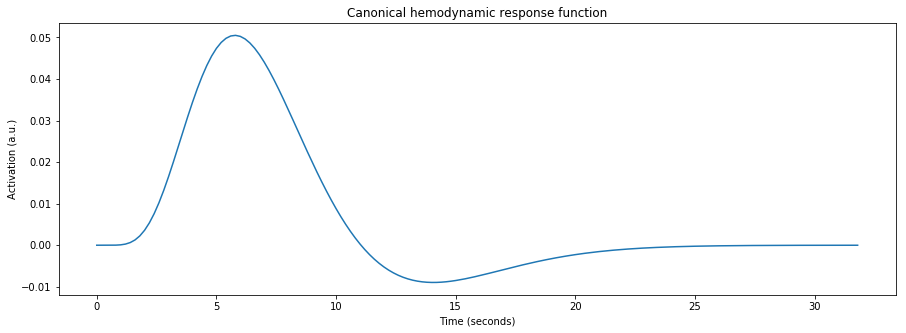

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(time_hrf_oversampled, hrf_oversampled)
plt.title("Canonical hemodynamic response function")
plt.xlabel("Time (seconds)")
_ = plt.ylabel("Activation (a.u.)")

#### Breakout Session

1\. Let's play with the parameters of the `create_hrf` function to see how they affect the HRF. First display the help file (docstring) for the `create_hrf` function using the `?`. 

In [59]:
### ANSWER BREAKOUT SESSION HERE
create_hrf?

2\. Change the `TR=1` and replot the HRF. How does it change? Does this change affect the size of the HRF array returned? If yes, why?

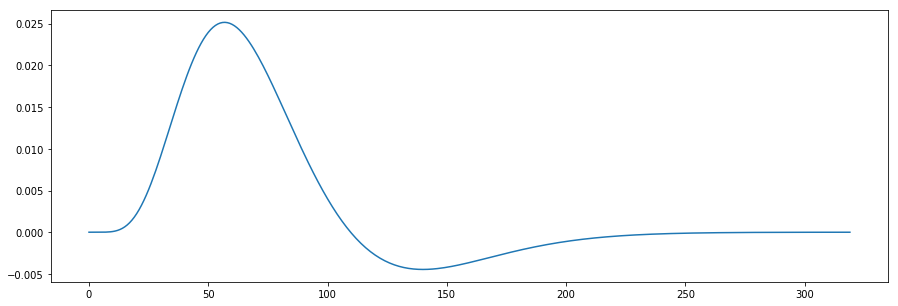

In [61]:
### ANSWER BREAKOUT SESSION HERE
hrf_breakout1 = create_hrf(tr=1, oversampling=oversampling, time_length=time)
plt.figure(figsize=(15, 5))
plt.plot(hrf_breakout1)

3\. Change the `oversampling=5`. How does it change? Does this change affect the size of the HRF array returned? If yes, why?

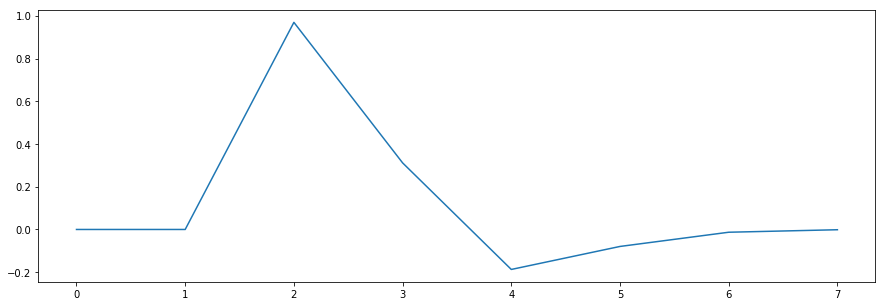

In [65]:
### ANSWER BREAKOUT SESSION HERE
hrf_breakout1 = create_hrf(tr=4, oversampling=1, time_length=time)
plt.figure(figsize=(15, 5))
plt.plot(hrf_breakout1)

4\. Change the `time_length=20`. How does it change? Does this change affect the size of the HRF array returned? If yes, why?

In [ ]:
### ANSWER BREAKOUT SESSION HERE

5\. Change the `onset=5`. How does it change? Does this change affect the size of the HRF array returned? If yes, why?

In [ ]:
### ANSWER BREAKOUT SESSION HERE

<a id="Response_Vector"></a>
### Response Vectors and the HRF
As mentioned above, an ***impulse response function*** describes how a system (in this case a brain) converts an event (or stimulus in this case) into a response (or BOLD signal in this case). The HRF is the **impulse response function** that neuroscientists have empirically defined that can be used to create an expected **response vector** from a known **stimulus vector**. 

As mentioned above, the **stimulus vector** is the vector of true and false values indicating the presence or absence of a given stimulus type (e.g. faces). The **response vector** is what we expect the BOLD signal to look like for a voxel that is responsive to that type of stimulus. To create a **response vector** we will combine  a **stimulus vector** with an **HRF**. 

Let's get comfortable with creating response vectors on some toy examples first. We'll first create a second HRF that has no oversampling, meaning there is one value for every TR.

In [66]:
hrf = create_hrf(tr=TR, oversampling=1, time_length=time)
hrf_length = hrf.shape[0]
hrf_length

16

Now let's plot this hrf so you can see the effect that oversampling has on the function:

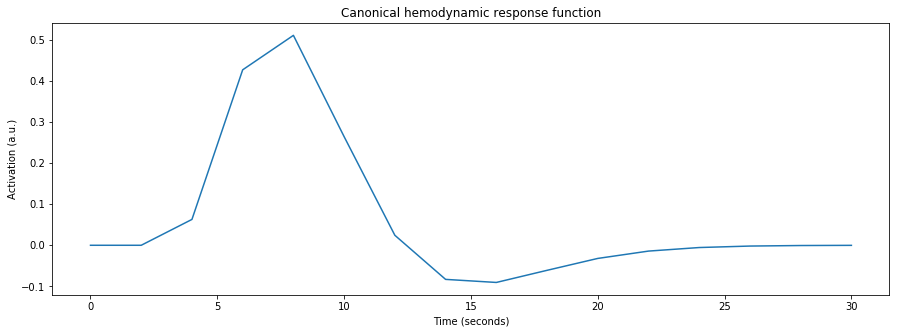

In [67]:
time_hrf = np.arange(0, time, TR)
plt.figure(figsize=(15, 5))
plt.plot(time_hrf, hrf)
plt.title("Canonical hemodynamic response function")
plt.xlabel("Time (seconds)")
_ = plt.ylabel("Activation (a.u.)")

You can see it is much choppier, not as smooth. Next we'll create a very simple stimulus vector with an event that occurrs at `TR=4` and is as long as this new HRF.

In [68]:
stimulus_time4 = np.zeros(hrf.shape)
stimulus_time4[4] = 1

Let's plot this toy stimulus:

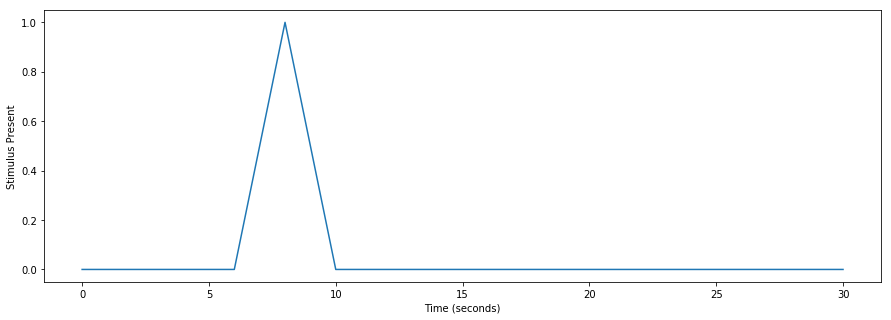

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(time_hrf, stimulus_time4)
plt.xlabel('Time (seconds)')
_ = plt.ylabel('Stimulus Present')

There is a better function that we can use to make this plot more explicit, meaning it will show the nature of the stimulus presentation as just occuring in a single TR, not spread out over a triangle like the above plot shows. It's called `plt.stem`.

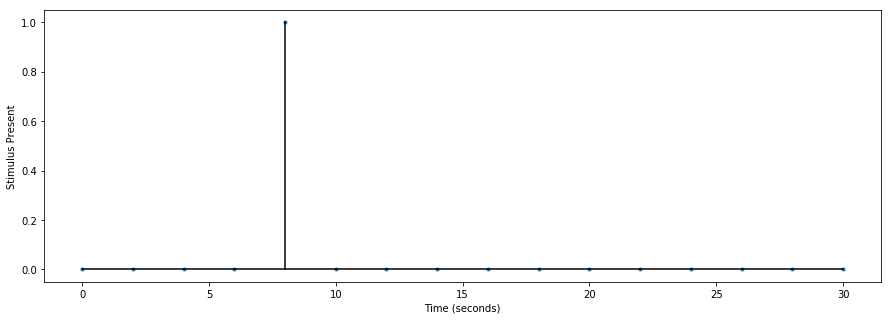

In [70]:
plt.figure(figsize=(15, 5))
plt.stem(time_hrf, stimulus_time4, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')
plt.xlabel('Time (seconds)')
_ = plt.ylabel('Stimulus Present')

Now let's create a second toy stimulus that starts at `TR=0`

In [71]:
stimulus_time0 = np.zeros(hrf.shape)
stimulus_time0[0] = 1

And plot this:

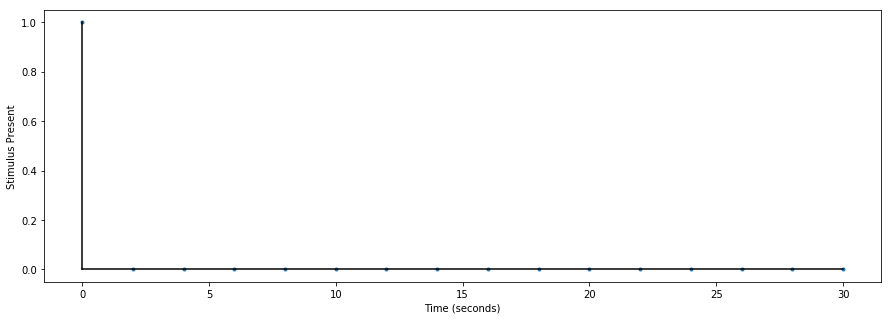

In [72]:
plt.figure(figsize=(15, 5))
plt.stem(time_hrf, stimulus_time0, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')
plt.xlabel('Time (seconds)')
_ = plt.ylabel('Stimulus Present')

Since the HRF we've created is the impulse response function for an event (stimulus) that starts at `TR=0`, the HRF we've created **IS** the response vector for this simple stimulus vector! Let's plot both of them together:

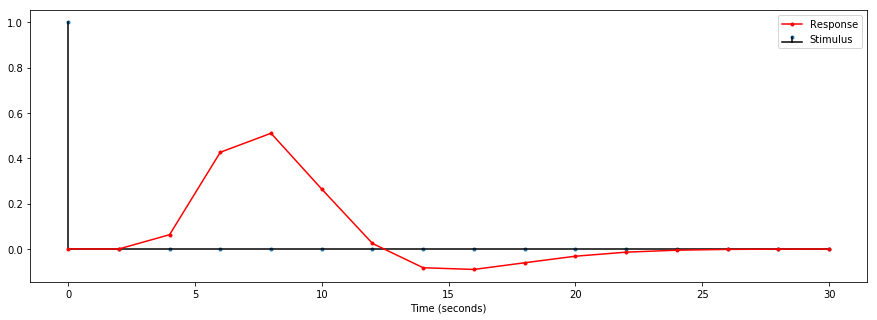

In [73]:
plt.figure(figsize=(15,5))
plt.stem(time_hrf, stimulus_time0, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')
plt.plot(time_hrf, hrf, 'r.-', label='Response')
plt.xlabel('Time (seconds)')
_ = plt.legend()

Let's put this plotting code into a function, as we'll be making more of these plots.

In [74]:
# We will be plotting stimulus / response pairs several times
# Hence, here is a function that can plot these two together
def stim_resp_plot(t, stimulus, response, label_stim='Stimulus', label_resp='BOLD response (HRF)'):
    """Plot stimulus and response."""
    plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label=label_stim)
    plt.plot(t, response, 'r.-', label=label_resp)
    plt.xlim([-1,t.max()+1])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Response (arbitrary units)')
    _ = plt.legend()

#### Breakout Session
1\. Let's practice using the `plt.stem` function. First, create a fake stimulus vector that is 100 TRs in length and has a stimulus presented every 4th TR, starting at the first TR (index=`0`). Call it `stimulus_breakout1`.

In [75]:
### ANSWER BREAKOUT SESSION HERE
stimulus_breakout1 = np.zeros((100))
stimulus_breakout1[::4] = 1
stimulus_breakout1.shape

(100,)

2\. Plot `stimulus_breakout1` using `plt.stem`. Label the X and Y axes with the appropriate labels.

<Container object of 3 artists>

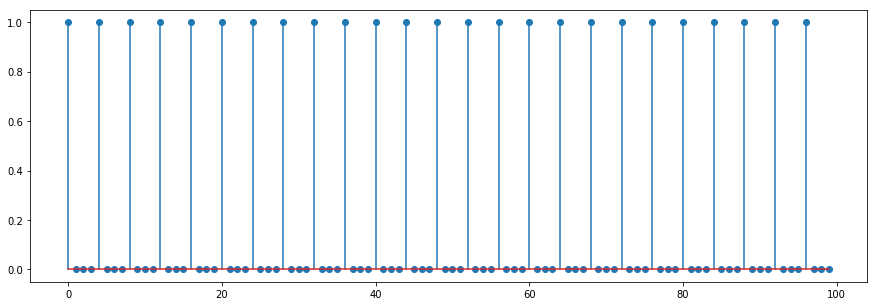

In [77]:
### ANSWER BREAKOUT SESSION HERE
fig = plt.figure(figsize=(15,5))
plt.stem(stimulus_breakout1)

### Creating Response Vectors from Stimulus Vectors and the HRF

Every time an event (stimulus) occurs, we expect the BOLD signal response we measure to be similar to this HRF if the neurons in a given voxel fire in response to the event. We'll use this principle to determine how to combine the stimulus vector and HRF to create the response vector. 

First, we'll start simple and create a hypothetical run of 200 TRs in which a single stimulus is presented at `TR=10` and figure out how to create the response vector for it.

In [78]:
n = 200 # number of TRs in this hypothetical run
i = 10 # index where the stimulus is presented

In [79]:
fMRI_stimulus0 = np.zeros(n)
fMRI_stimulus0[i] = 1
fMRI_stimulus0.shape

(200,)

Let's plot this stimulus vector to have a look:

In [92]:
time_fMRI = np.arange(0,n*TR,TR)

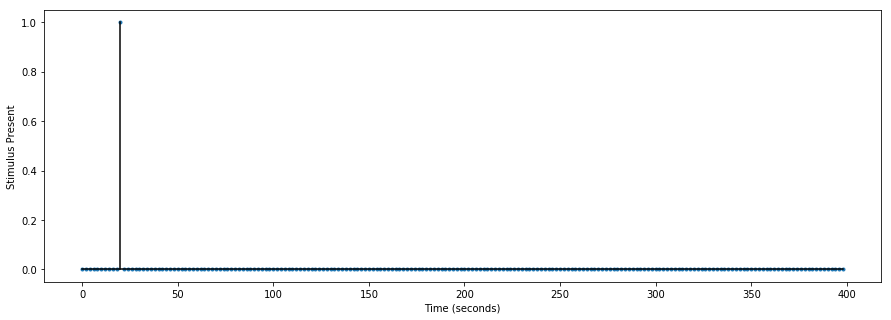

In [93]:
plt.figure(figsize=(15, 5))
plt.stem(time_fMRI, fMRI_stimulus0, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')
plt.xlabel('Time (seconds)')
_ = plt.ylabel('Stimulus Present')

In voxels that respond to the stimulus type this stimulus vector represents, an HRF will be induced starting at `TR=10` and lasting as long as the HRF lasts, which is 32 seconds, or 16 2-second TRs. 

Thus, to create the response vector for this stimulus vector, we need to add the HRF to a vector of zeros, starting at the TR where the stimulus was presented, and ending hrf_length (16) later. We can use indexing to do this. Let's first create an vector of zeros to store the response.

In [82]:
fMRI_response0 = np.zeros((n,))

Now want to copy the HRF values to the response vector, starting where the stimulus `i` first appears, and ending the number of TRs in the HRF past this starting point. Let's create names to store the start and end indices.

In [83]:
start_idx = i
end_idx = start_idx + hrf_length

Now let's copy the hrf values to the response vector from the start to the end indices.

In [84]:
fMRI_response0[start_idx:end_idx] = hrf

Finally, let's plot the stimulus and response vectors together using the helper function we've already created.

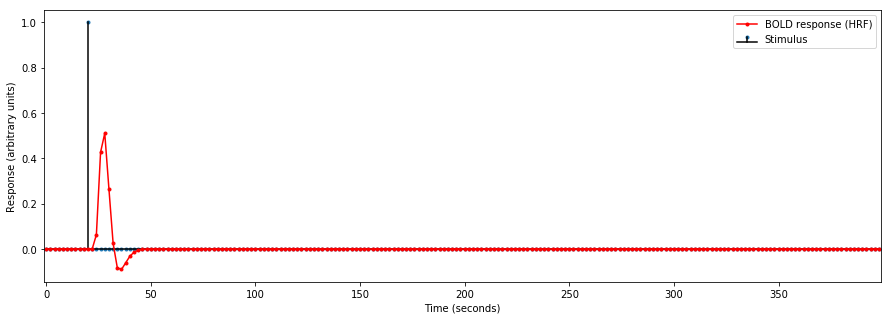

In [85]:
fig = plt.figure(figsize=(15,5))
stim_resp_plot(time_fMRI, fMRI_stimulus0, fMRI_response0)

We see that the HRF starts just after the stimulus is presented, which is what we expect!

Any non-trivial experiment that lasts 200 TRs will have more than one stimulus. Let's see how we can account for multiple TRs. First we'll define a list that contains the time (in TRs) when the stimuli were presented:

In [86]:
stim_times1 = [10,70,150]

Now we can create the stimulus vector by looping over the stimulus presentation times and storing a one in the vector:

In [87]:
fMRI_stimulus1 = np.zeros((n))
for i in stim_times1:
    fMRI_stimulus1[i] = 1

In [95]:
time_fMRI.shape

(200,)

<Container object of 3 artists>

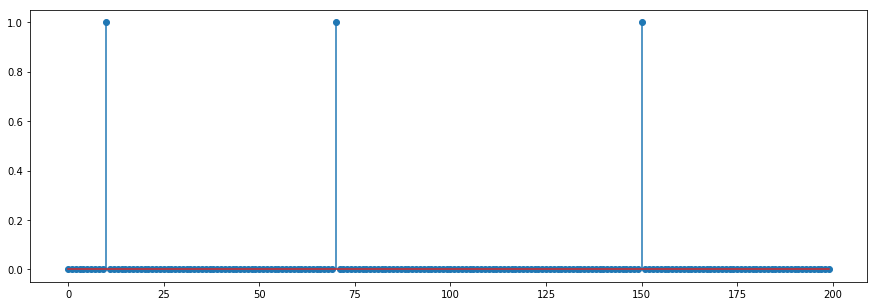

In [96]:
fig = plt.figure(figsize=(15,5))
plt.stem(fMRI_stimulus1)

Now let's create the response vector. First we'll create a vector with all 0s, then loop over the stim times and for each one, we'll calculate the start and stop indices for the HRF, then copy the HRF into the response vector.

In [97]:
fMRI_response1 = np.zeros((n))
for i in stim_times1:
    cur_start_idx = i
    cur_end_idx = i + hrf_length
    fMRI_response1[cur_start_idx:cur_end_idx] = hrf

Now let's plot the result!

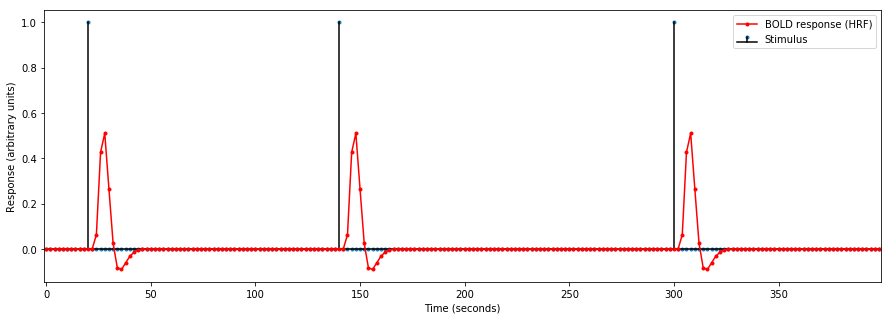

In [98]:
fig = plt.figure(figsize=(15,5))
stim_resp_plot(time_fMRI, fMRI_stimulus1, fMRI_response1)

#### Breakout Session

1\. Create a stimulus vector that is 200 TRs in length, and has stimuli presented at times `[25,75,125,175]`, and call it `fMRI_stimulus2`.

In [ ]:
### ANSWER BREAKOUT SESSION HERE

2\. Create a response vector for these same stimuli using the technique we just covered, and call it `fMRI_response2`.

In [ ]:
### ANSWER BREAKOUT SESSION HERE

3\. Plot `fMRI_stimulus2` and `fMRI_response2` in the same plot using the helper function `stim_resp_plot`.

In [ ]:
### ANSWER BREAKOUT SESSION HERE

### Response Vectors with Overlapping HRFs

We've now created several response vectors when the stimuli were far apart, far enough in fact that the HRF we copied does not overlap. This is usually not the case in real-world fMRI studies however.

When the stimuli are close enough that the HRF would overlap, what does the BOLD signal look like? It could just add the two HRFs. It could multiply them. It could do any number of things, but it turns out that research in the late 90s shows that the BOLD signal is added up, or it **sums linearly** in the terminology of those studies. See this [seminal study](#http://math.bu.edu/people/horacio/tutorials/DaleBucknerHumBrainMap1997_fmri_evtrelated.pdf) for more details.

To account for this addition of the HRF we'll have to modify our calculations slightly. Let's first put the code to create a stimulus vector into a helper function:

In [99]:
def create_stimuli(t, stim_times):
    stimuli = np.zeros((len(t),))
    for i in stim_times:
        stimuli[i] = 1
    return stimuli

And now we'll create another hypothetical run with stimuli at TRs `[10,12,24,100,104,106]` and use the helper function to create the stimulus vector:

In [100]:
stim_times3 = [10,12,14,100,104,108]
fMRI_stimulus3 = create_stimuli(time_fMRI, stim_times3)
fMRI_stimulus3.shape

(200,)

Now to account for the linear summation of the HRF, instead of just copying the HRF into the appropriate TRs we'll add it using the `+=` operator in the last line of the for loop:

In [105]:
fMRI_response3 = np.zeros(n)
for i in stim_times3:
    cur_start_idx = i
    cur_end_idx = i + hrf_length
    fMRI_response3[cur_start_idx:cur_end_idx] += hrf

Let's plot this new pair of stimulus and response vectors:

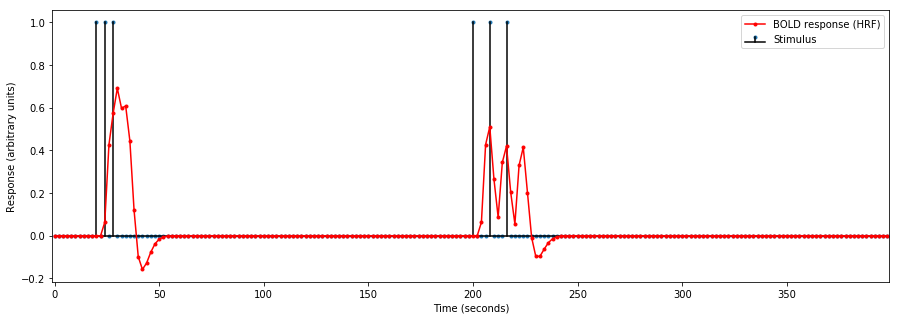

In [106]:
fig = plt.figure(figsize=(15,5))
stim_resp_plot(time_fMRI, fMRI_stimulus3, fMRI_response3)

We can see in the first set of stimuli that when the stimuli are presented just 2 TRs (4 seconds) apart, the BOLD signal never dips down, it just keeps increasing! And in the second set of stimuli where they are spaced 4 TRs (8 seconds) apart, the BOLD signal drops down, but never gets back to baseline. 

#### Breakout Session

1\. Create a stimulus vector for stimuli presented at TR `[10, 21, 25, 70, 71,74, 75, 80, 150]` and call it `fMRI_stimulus4`.

In [107]:
### ANSWER BREAKOUT SESSION HERE
stim_times4 = [10, 21, 25, 70, 71,74, 75, 80, 150]
fMRI_stimulus4 = create_stimuli(time_fMRI, stim_times4)
fMRI_stimulus4.shape

(200,)

2\. Create the response vector for this stimulus vector and call it `fMRI_response4`.

In [108]:
### ANSWER BREAKOUT SESSION HERE
fMRI_response4 = np.zeros(n)
for i in stim_times4:
    cur_start_idx = i
    cur_end_idx = i + hrf_length
    fMRI_response4[cur_start_idx:cur_end_idx] += hrf

3\. Plot this new pair of stimulus and response vectors.

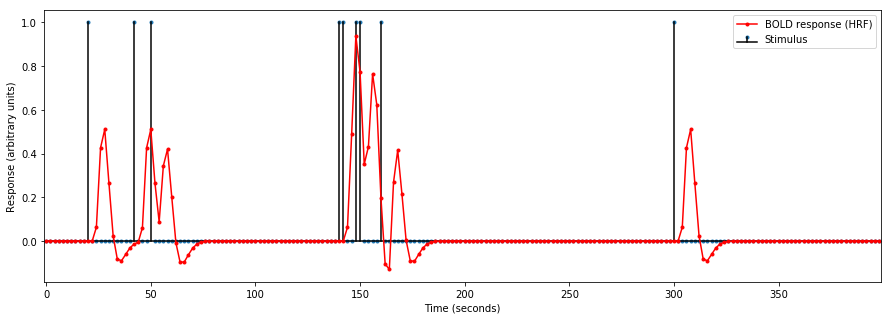

In [109]:
### ANSWER BREAKOUT SESSION HERE
fig = plt.figure(figsize=(15,5))
stim_resp_plot(time_fMRI, fMRI_stimulus4, fMRI_response4)

### Response Vectors at the end of the Stimulus Vector

When a stimulus occurs at the end of the stimulus vector, the HRF may be too long to add to the response vector. In this case we need to truncate the HRF and only add the part of it that can fit. Let's see how to do that now by creating a stimulus vector with a stimulus at `TR=190`

In [110]:
stim_times5 = [190]
fMRI_stimulus5 = create_stimuli(time_fMRI, stim_times5)

In order to truncate the HRF, we'll make sure that the `cur_end_idx` we create doesn't go past the end of the response vector using `np.men`, and then calculate how much of the HRF to add by subtracting the start index from the end index.

In [111]:
fMRI_response5 = np.zeros((n,))
for i in stim_times5:
    start_idx = i
    end_idx = np.min((start_idx + hrf_length, n))
    cur_hrf_length = end_idx - start_idx
    print(cur_hrf_length)
    fMRI_response5[start_idx:end_idx] += hrf[:cur_hrf_length]

10


Let's see what it looks like:

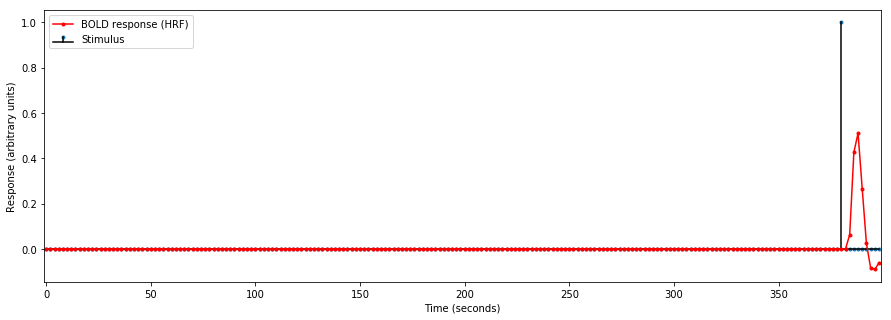

In [112]:
fig = plt.figure(figsize=(15,5))
stim_resp_plot(time_fMRI, fMRI_stimulus5, fMRI_response5)

We see that the HRF doesn't get a chance to return to baseline because it is truncated!

# Convolution
<a id="Convolution"></a>
The calculations we did in these last few sub-sections to create the response vector from the stimulus vector and the HRF actually has a name, it is called **convolution**.

Convolution is an operation that works on two vectors or functions (stimulus vector and HRF in this case) and produces a third vector that is the sum of the pointwise multiplication of shifted copies of the two input vectors. In other words, convolution moves through each time point in the first vector (stimulus in our case) and multiplies the second function (HRF) by the value in the current timepoint, and then adds all those values into the output vector (response). By doing this, previous values of the signal (before time i) affect the new transformed signal (at time i). 

Here's a visualization that let's you adjust how far the convolution goes in creating the response vector:

In [113]:
stim_times_interact = np.arange(0,n,4)
stimulus_interact = create_stimuli(time_fMRI,stim_times_interact)

response_interact = np.zeros((n))
for i in stim_times_interact:
    start_idx = i
    end_idx = np.min((start_idx + hrf_length, n))
    cur_hrf_length = end_idx - start_idx
    response_interact[start_idx:end_idx] += hrf[:cur_hrf_length]    

In [114]:
def plot_convolution(i):
    response_interact_live = np.zeros(n)
    response_interact_live[:i] = response_interact[:i]
    plt.figure(figsize=(15,5))
    stim_resp_plot(time_fMRI, stimulus_interact, response_interact_live)

_ = interact(plot_convolution, i=widgets.IntSlider(min=0,max=n-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='i', max=199), Output()), _dom_classes=('widget-interact',))

## `np.convolve()`

Convolution is a common operation in many signal processing fields. Numpy has a function called `np.convolve()` that we'll use to convolve the stimulus vector with the HRF to create the response vector. Let's use it to calculate the response vector for some of the stimulus vectors we created above.

In [120]:
fMRI_response4_conv = np.convolve(fMRI_stimulus4, hrf, mode='full')
fMRI_response4_conv.shape

(215,)

The `np.convolve` function deals with the problem of truncating the HRF for stimuli near the end by not truncating at all! Instead, it always returns a response vector that is the length of the stimulus vector plus the lenght of the HRF - 1, which is why the response vector we just created is length 215 (200 + 16-1).

All that means is we always have to truncate the response vector returned from `np.convolve` ourselves. 

**NOTE:** There is another `mode=same` that `np.convolve` can use that will return a vector that is the same length as the input vector (stimulus vector in this case). This is **NOT** what we want to use however because it calculates the convolution slightly differently. Be forewarned!

In [121]:
fMRI_response4_conv = fMRI_response4_conv[:n]
fMRI_response4_conv.shape

(200,)

That looks better! Now let's verify that what we were doing above gives us the same result as `np.convolve`. We'll check that all 200 floating point values in both response vectors are essentially the same using `np.allclose`:

In [122]:
conv_equal = np.allclose(fMRI_response4,fMRI_response4_conv)
conv_equal

True

#### Breakout Session
1\. Use `np.convolve()` to create a response vector by convolving the hypothetical fMRI signal created below named `stimulus_breakout1` with the HRF function. Call this response vector `response_breakout1`. Then plot both the stimulus and response using `stim_resp_plot`.

In [ ]:
stim_times_breakout1 = [0,10,20,29,40,48,60,67,80,86,100,105,120,124,140,143,160,162,180,181]
stimulus_breakout1 = create_stimuli(time_fMRI,stim_times_breakout1)
    
### ANSWER BREAKOUT SESSION HERE

2\. Do the same thing as in question #1, but for this new stimulus vector that was created by assuming that we have a _blocked_ stimulus, i.e. the simulus is on for 30 seconds, starting at 10, 70 and 130. How does the response change?

In [ ]:
stim_times_breakout2 = list(range(10, 40)) + list(range(70, 100))+ list(range(130, 160))
stimulus_breakout2 = create_stimuli(time_fMRI,stim_times_breakout2)
    
### ANSWER BREAKOUT SESSION HERE

## Convolving real fMRI data

Now that we've defined what the convolution function does, we'll use it with some real data to make a response vector that looks like a better match to the BOLD data than the stimulus vector.

First, let's plot the BOLD data from the FFA voxel that we loaded at the beginning of lecture, along with it's stimulus vector.

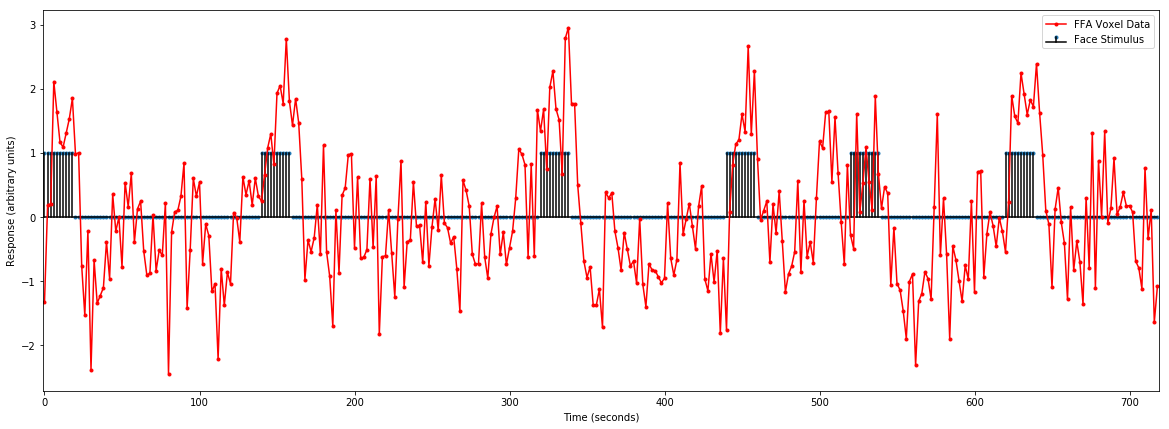

In [123]:
fig = plt.figure(figsize=(20,7))
stim_resp_plot(time_whole, stimulus_vector_faces, ffa_timeseries, label_stim='Face Stimulus', label_resp='FFA Voxel Data')

That's a busy plot, so let's zoom in to the first 100 time points.

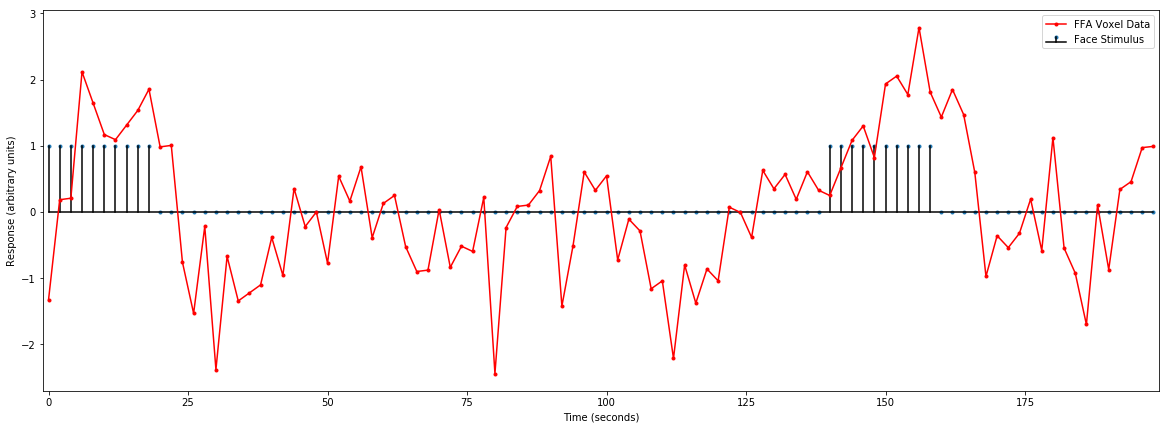

In [124]:
fig = plt.figure(figsize=(20,7))
stim_resp_plot(time_whole[:100], stimulus_vector_faces[:100], ffa_timeseries[:100], 
               label_stim='Face Stimulus', label_resp='FFA Voxel Data')

The presentation of the stimulus should create a hemodynamic response if this voxel is sensitive to that stimulus. We therefore need to convolve the stimulus first with the hemodynamic response function. 

Let's convolve the faces stimulus vector with the HRF.

In [125]:
response_vector_faces = np.convolve(stimulus_vector_faces, hrf, mode='full')[:num_TRs]

Then use the `stim_resp_plot` to plot both the stimulus vector and the convolved response vector together.

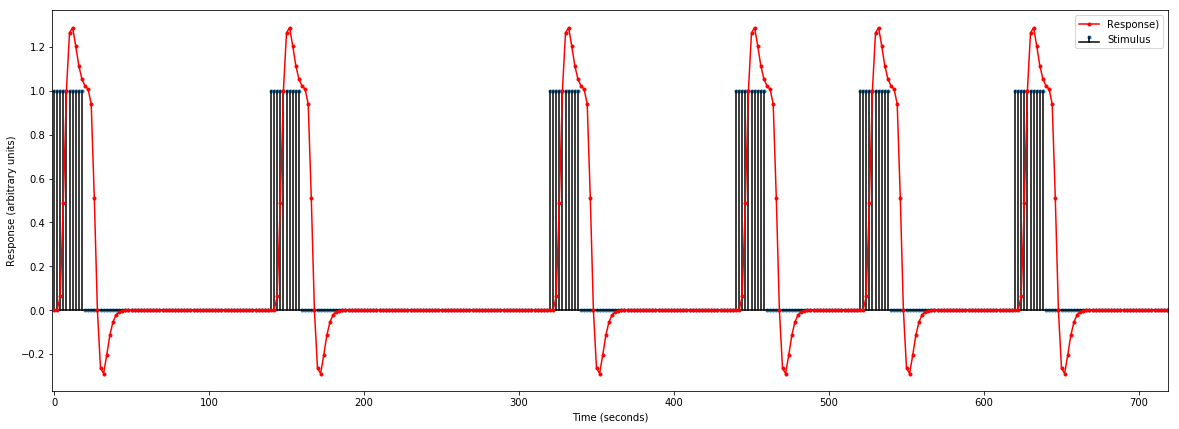

In [126]:
fig = plt.figure(figsize=(20,7))
stim_resp_plot(time_whole, stimulus_vector_faces, response_vector_faces, label_stim='Stimulus', label_resp='Response)');

2\. Again let's zoom into the first 100 time points of the same plot:

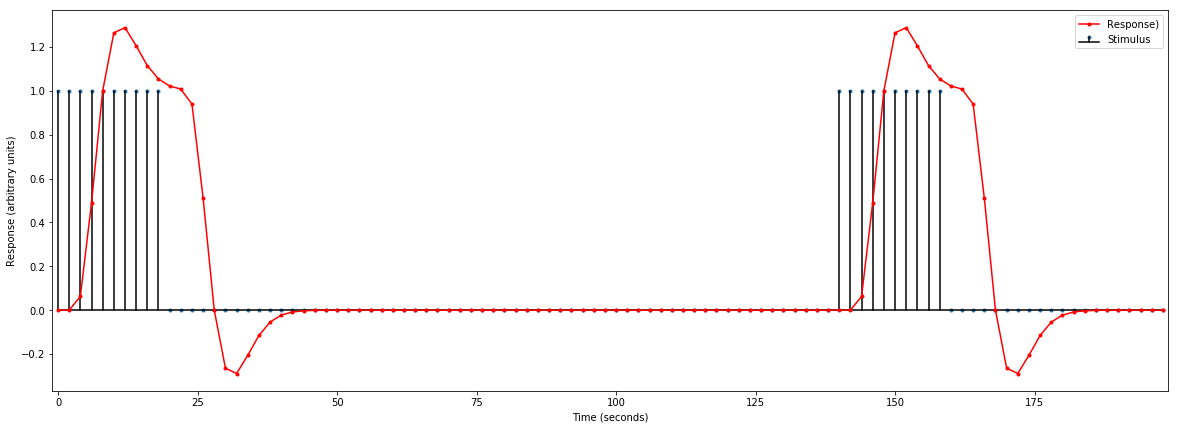

In [127]:
fig = plt.figure(figsize=(20,7))
stim_resp_plot(time_whole[:100], stimulus_vector_faces[:100], response_vector_faces[:100], label_stim='Stimulus', label_resp='Response)');

### Compare the Stimuli and Response Vectors to the BOLD Data

Now let's make 2 plots of the BOLD data, one that compares it with the stimulus vector, and the second that compares it with the response vector. Which do you expect to look more similar to the BOLD data, the stimulus or response vector?

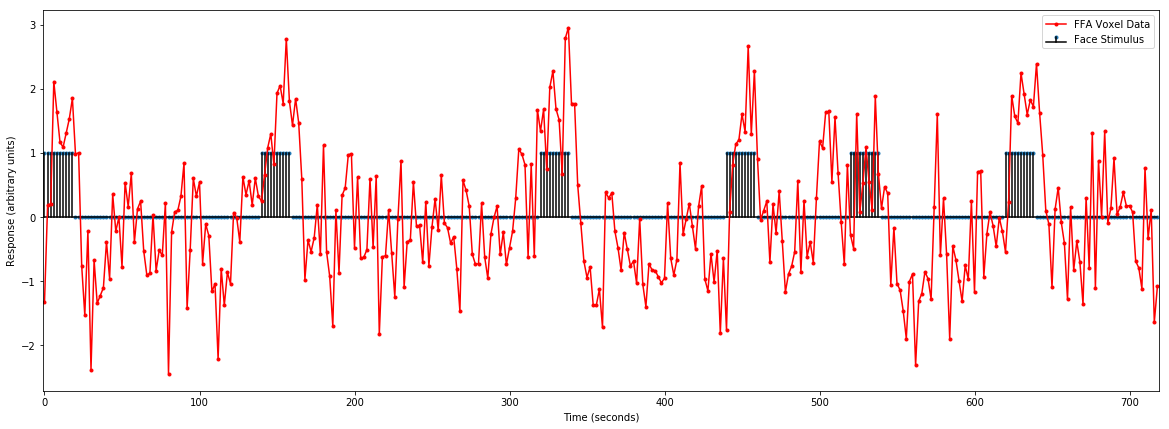

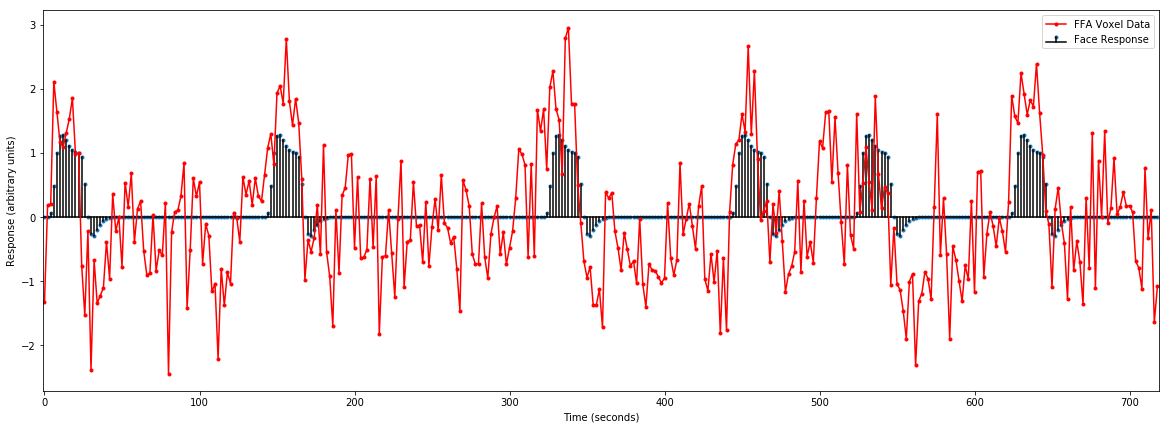

In [128]:
fig = plt.figure(figsize=(20,7))
stim_resp_plot(time_whole, stimulus_vector_faces, ffa_timeseries, 
               label_stim='Face Stimulus', label_resp='FFA Voxel Data')
fig = plt.figure(figsize=(20,7))
stim_resp_plot(time_whole, response_vector_faces, ffa_timeseries, 
               label_stim='Face Response', label_resp='FFA Voxel Data')

Next week we'll see how to quantify the similarity between two signals in order to determine whether accounting for the HRF improves the similarity between the BOLD data and the response vector.